In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/social-media-sentiments-analysis-dataset/sentimentdataset.csv


In [104]:
filename = "/kaggle/input/social-media-sentiments-analysis-dataset/sentimentdataset.csv"

df = pd.read_csv(filename)
df.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [105]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')

In [106]:
# drop a column
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'], axis=1)

In [107]:
!pip install vaderSentiment -q

In [108]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [109]:
analyze = SentimentIntensityAnalyzer()

def sentiment_score(review):
    score = analyze.polarity_scores(review)
    if score['compound'] >= 0.05:
        return 'positive'
    elif score['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [110]:
df['Sentiment'] = df['Text'].apply(sentiment_score)

In [111]:
df.head()

,Text,Sentiment
0,Enjoying a beautiful day at the park! ...,positive
1,Traffic was terrible this morning. ...,negative
2,Just finished an amazing workout! 💪 ...,positive
3,Excited about the upcoming weekend getaway! ...,positive
4,Trying out a new recipe for dinner tonight. ...,neutral


In [112]:

label_map = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

# Apply mapping
df['label'] = df['Sentiment'].map(label_map)

# Verify conversion
df[['Text', 'label']].head()

,Text,label
0,Enjoying a beautiful day at the park! ...,2
1,Traffic was terrible this morning. ...,0
2,Just finished an amazing workout! 💪 ...,2
3,Excited about the upcoming weekend getaway! ...,2
4,Trying out a new recipe for dinner tonight. ...,1


In [113]:
df['label'].value_counts()

label
2    466
0    184
1     82
Name: count, dtype: int64

In [114]:
df.to_csv('df.csv', index=False)

In [115]:
from imblearn.over_sampling import SMOTE

In [116]:
# Extract the labels for resampling
X = df[['label']].values.reshape(-1, 1)  # Reshape to fit the expected input format
y = df['label']

# Perform random oversampling
ros = SMOTE(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)


df_resampled = pd.DataFrame(X_resampled, columns=['resampled_label'])
df_resampled['resampled_label'] = y_resampled

# Merge resampled labels as a new column into the original dataset
# Note: This will add duplicate rows for the oversampled data. 
df = pd.concat([df, df_resampled], axis=1)

In [117]:
df.head()

,Text,Sentiment,label,resampled_label
0,Enjoying a beautiful day at the park! ...,positive,2.0,2
1,Traffic was terrible this morning. ...,negative,0.0,0
2,Just finished an amazing workout! 💪 ...,positive,2.0,2
3,Excited about the upcoming weekend getaway! ...,positive,2.0,2
4,Trying out a new recipe for dinner tonight. ...,neutral,1.0,1


In [118]:
df['resampled_label'].value_counts()

resampled_label
2    466
0    466
1    466
Name: count, dtype: int64

In [119]:
# Select only the 'Text' and 'resampled_label' columns
df_selected = df[['Text', 'resampled_label']]

In [120]:
df = df_selected

In [121]:
!pip install transformers datasets  -q

In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from datasets import Dataset as HFDataset
import pandas as pd
from collections import Counter
import time

In [123]:
from transformers import AutoTokenizer
import pandas as pd


# Check for and handle any potential NaN values or non-string entries in the 'Text' column
df['Text'] = df['Text'].fillna('').astype(str)

# Load a tokenizer from Hugging Face
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example to confirm tokenization works
print(f"Example text: {df.iloc[0]['Text']}")
print(f"Tokenized text: {tokenizer(df.iloc[0]['Text'])}")
print(f"Example label: {df.iloc[0]['resampled_label']}")

# Assuming you have a label mapping, if not, you might need to define one based on your labels
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}  # Example mapping
print(f"Label Mapping: {label_map}")

Example text:  Enjoying a beautiful day at the park!              
Tokenized text: {'input_ids': [101, 9107, 1037, 3376, 2154, 2012, 1996, 2380, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Example label: 2
Label Mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [206]:
# Convert the Pandas DataFrame to Hugging Face Dataset format
hf_dataset = HFDataset.from_pandas(df)
print(hf_dataset)

# Tokenization Function
def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True, max_length = 512)

tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)

# remove `text` column
tokenized_dataset = tokenized_dataset.remove_columns(["Text"])

# Convert to pytorch format
tokenized_dataset.set_format("torch", columns = ["input_ids", "attention_mask", "resampled_label"])
print(tokenized_dataset)

Dataset({
    features: ['Text', 'resampled_label'],
    num_rows: 1398
})


Map:   0%|          | 0/1398 [00:00<?, ? examples/s]

Dataset({
    features: ['resampled_label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1398
})


In [207]:
tokenized_dataset

Dataset({
    features: ['resampled_label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1398
})

In [295]:
BATCH_SIZE = 32
dataloader = DataLoader(
        tokenized_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )

In [296]:
# --- Start of the Model Definition ---
class InputProjection(nn.Module):
    def __init__(self, input_dim, d_k):
        super().__init__()
        self.input_dim = input_dim
        self.d_k = d_k  # dimension of key/query/value
        self.wq = nn.Linear(input_dim, d_k)
        self.wk = nn.Linear(input_dim, d_k)
        self.wv = nn.Linear(input_dim, d_k)

    def forward(self, x):
        q = self.wq(x)  # [batch_size, seq_len, d_k]
        k = self.wk(x)  
        v = self.wv(x)  
        return q, k, v

class AdditiveAttention(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        

    def forward(self, x):  # input x is Q [batch_size, seq_len, d_k]
        # Calculate global query vector by taking the mean of all query vectors along the sequence length dimension
        global_query = torch.mean(x, dim=1)  
        return global_query  

class GlobalContextKey(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.wk = nn.Linear(d_k, 1)  # parameter vector w_k
        self.additive_attention = AdditiveAttention(d_k)

    def forward(self, key_matrix, global_query):
        # key_matrix: [batch_size, seq_len, d_k]
        # global_query: [batch_size, d_k]
        # Element-wise multiplication with global query (broadcasted)
        context_aware_key_matrix = key_matrix * global_query.unsqueeze(1)  # [batch_size, seq_len, d_k]
        # Reduce along sequence dimension via additive attention (i.e. averaging)
        global_key_vector = self.additive_attention(context_aware_key_matrix)  # [batch_size, d_k]
        return global_key_vector, context_aware_key_matrix

class GlobalContextValue(nn.Module):
    def __init__(self, d_k):
        super().__init__()

    def forward(self, value_matrix, global_key):
        # value_matrix: [batch_size, seq_len, d_k]
        # global_key: [batch_size, d_k]
        global_context_aware_value = value_matrix * global_key.unsqueeze(1)  # [batch_size, seq_len, d_k]
        return global_context_aware_value

class OutputTransformation(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.linear_transform = nn.Linear(d_k, d_k)

    def forward(self, global_context_aware_value, query_matrix):
        transformed_value = self.linear_transform(global_context_aware_value)
        # Add the original Q with the transformed value.
        output = transformed_value + query_matrix
        return output

class FastformerLayer(nn.Module):
    def __init__(self, input_dim, d_k):
        """
        input_dim: Dimension of the input (e.g., 512 for the first layer and d_k for subsequent layers)
        d_k: The dimension for the keys/queries/values.
        """
        super().__init__()
        self.input_projection = InputProjection(input_dim, d_k)
        self.additive_attention = AdditiveAttention(d_k)
        self.global_context_key = GlobalContextKey(d_k)
        self.global_context_value = GlobalContextValue(d_k)
        self.output_transformation = OutputTransformation(d_k)

    def forward(self, x):
        # x: [batch_size, seq_len, input_dim]
        q, k, v = self.input_projection(x)  # q, k, v: [batch_size, seq_len, d_k]
        global_query = self.additive_attention(q)  # [batch_size, d_k]
        global_key_vector, _ = self.global_context_key(k, global_query)  # [batch_size, d_k]
        global_context_aware_value = self.global_context_value(v, global_key_vector)  # [batch_size, seq_len, d_k]
        output = self.output_transformation(global_context_aware_value, q)  # [batch_size, seq_len, d_k]
        return output



In [297]:
class FastformerForSentimentAnalysis(nn.Module):
    def __init__(self, vocab_size, d_model, d_k, num_classes, dropout=0.1):
        """
        d_model: Dimension for the embeddings (and first layer input).
        d_k: The dimension used within Fastformer layers.
        """
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.fastformer = nn.Sequential(
            FastformerLayer(d_model, d_k),  # first layer: input dim is d_model (e.g., 512) -> outputs d_k (e.g., 64)
            FastformerLayer(d_k, d_k)       # subsequent layer: input and output dims are d_k
            # You can add more layers here with (d_k, d_k) if needed.
        )
        self.dropout = nn.Dropout(dropout)
        self.pooling = nn.AdaptiveAvgPool1d(1)  # pool along the sequence dimension
        self.linear = nn.Linear(d_k, num_classes)  # classifier now expects d_k features

    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, d_model]
        encoded = self.fastformer(embedded)  # first layer converts to [batch_size, seq_len, d_k], and so on.
        # Pool over the sequence dimension.
        pooled = self.pooling(encoded.transpose(1, 2)).squeeze(-1)  # [batch_size, d_k]
        pooled = self.dropout(pooled)
        logits = self.linear(pooled)  # [batch_size, num_classes]
        return logits


In [298]:
num_classes = 3

In [304]:
# Define hyperparameters
vocab_size = len(tokenizer)
d_model = 512
d_k = 64
learning_rate =  1.5625e-3
num_epochs = 35
dropout = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Initialize the model
model = FastformerForSentimentAnalysis(vocab_size, d_model, d_k, num_classes, dropout).to(device)




# Loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [305]:
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import time

# --- Split Dataset into Training and Validation ---
train_size = int(0.8 * len(tokenized_dataset))
val_size = len(tokenized_dataset) - train_size
train_dataset, val_dataset = random_split(tokenized_dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Training Loop with Evaluation Metrics ---
epoch_losses = []
epoch_accuracies = []
epoch_times = []

best_val_loss = float('inf')
patience = 5  
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    total_loss = 0
    
    # Training phase
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        labels = batch["resampled_label"].to(device)
        logits = model(input_ids)
        loss = loss_function(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    epoch_loss = total_loss / len(train_dataloader)
    epoch_losses.append(epoch_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["resampled_label"].to(device)
            logits = model(input_ids)
            val_loss += loss_function(logits, labels).item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss /= len(val_dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    epoch_accuracies.append(accuracy)
    
    elapsed_time = time.time() - start_time
    epoch_times.append(elapsed_time)
    
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}, Val F1: {f1:.4f}, Time: {elapsed_time:.2f}s")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement == patience:
            print(f"Early stopping triggered after {epoch+1} epochs without improvement")
            break


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 1/35, Train Loss: 1.1604, Val Loss: 1.0940, Val Accuracy: 0.3214, Val F1: 0.1564, Time: 0.58s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 2/35, Train Loss: 1.1010, Val Loss: 1.1231, Val Accuracy: 0.3786, Val F1: 0.2079, Time: 0.51s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 3/35, Train Loss: 1.2431, Val Loss: 1.1222, Val Accuracy: 0.5000, Val F1: 0.3992, Time: 0.51s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 4/35, Train Loss: 1.1329, Val Loss: 1.1307, Val Accuracy: 0.3000, Val F1: 0.1385, Time: 0.51s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 5/35, Train Loss: 1.1081, Val Loss: 1.0896, Val Accuracy: 0.3786, Val F1: 0.2079, Time: 0.52s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 6/35, Train Loss: 1.1010, Val Loss: 1.0923, Val Accuracy: 0.4607, Val F1: 0.3553, Time: 0.51s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 7/35, Train Loss: 1.0949, Val Loss: 1.1323, Val Accuracy: 0.3000, Val F1: 0.1385, Time: 0.51s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 8/35, Train Loss: 1.0943, Val Loss: 1.1380, Val Accuracy: 0.3000, Val F1: 0.1385, Time: 0.51s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 9/35, Train Loss: 1.0873, Val Loss: 1.0927, Val Accuracy: 0.3214, Val F1: 0.1564, Time: 0.51s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 10/35, Train Loss: 1.0897, Val Loss: 1.0832, Val Accuracy: 0.3286, Val F1: 0.1772, Time: 0.51s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 11/35, Train Loss: 1.0589, Val Loss: 1.1041, Val Accuracy: 0.3000, Val F1: 0.1385, Time: 0.52s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 12/35, Train Loss: 1.0967, Val Loss: 1.1986, Val Accuracy: 0.3214, Val F1: 0.1564, Time: 0.52s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 13/35, Train Loss: 60.4894, Val Loss: 300.5776, Val Accuracy: 0.3214, Val F1: 0.1564, Time: 0.52s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 14/35, Train Loss: 191.9660, Val Loss: 9.9751, Val Accuracy: 0.3214, Val F1: 0.1564, Time: 0.51s
Epoch: 15/35, Train Loss: 2.5505, Val Loss: 0.9627, Val Accuracy: 0.4321, Val F1: 0.4259, Time: 0.52s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 16/35, Train Loss: 0.9167, Val Loss: 0.9113, Val Accuracy: 0.5143, Val F1: 0.4152, Time: 0.52s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 17/35, Train Loss: 0.8308, Val Loss: 0.9268, Val Accuracy: 0.5071, Val F1: 0.3897, Time: 0.52s


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 18/35, Train Loss: 0.8167, Val Loss: 0.9079, Val Accuracy: 0.5143, Val F1: 0.4152, Time: 0.51s
Epoch: 19/35, Train Loss: 0.7837, Val Loss: 0.9519, Val Accuracy: 0.5357, Val F1: 0.4152, Time: 0.52s
Epoch: 20/35, Train Loss: 0.7537, Val Loss: 0.9583, Val Accuracy: 0.5429, Val F1: 0.4480, Time: 0.52s
Epoch: 21/35, Train Loss: 0.7998, Val Loss: 0.9280, Val Accuracy: 0.5250, Val F1: 0.4181, Time: 0.52s
Epoch: 22/35, Train Loss: 0.7577, Val Loss: 0.9424, Val Accuracy: 0.5179, Val F1: 0.4193, Time: 0.52s
Epoch: 23/35, Train Loss: 0.7552, Val Loss: 0.9073, Val Accuracy: 0.5357, Val F1: 0.4806, Time: 0.52s
Epoch: 24/35, Train Loss: 0.7390, Val Loss: 0.9293, Val Accuracy: 0.5393, Val F1: 0.4642, Time: 0.52s
Epoch: 25/35, Train Loss: 0.7726, Val Loss: 0.9111, Val Accuracy: 0.5500, Val F1: 0.4708, Time: 0.52s
Epoch: 26/35, Train Loss: 0.7319, Val Loss: 0.9040, Val Accuracy: 0.5429, Val F1: 0.4924, Time: 0.52s
Epoch: 27/35, Train Loss: 0.7134, Val Loss: 0.9291, Val Accuracy: 0.5429, Val F1: 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 29/35, Train Loss: 0.7011, Val Loss: 0.9471, Val Accuracy: 0.5429, Val F1: 0.4370, Time: 0.52s
Epoch: 30/35, Train Loss: 0.6944, Val Loss: 0.9052, Val Accuracy: 0.5500, Val F1: 0.4950, Time: 0.52s
Epoch: 31/35, Train Loss: 0.6990, Val Loss: 0.9548, Val Accuracy: 0.5429, Val F1: 0.4410, Time: 0.52s
Early stopping triggered after 31 epochs without improvement


In [308]:
 
    # --- Validation ---
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["resampled_label"].to(device)
            logits = model(input_ids)
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"Validation - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


Validation - Accuracy: 0.5429, Precision: 0.5710, Recall: 0.5429, F1-score: 0.4410


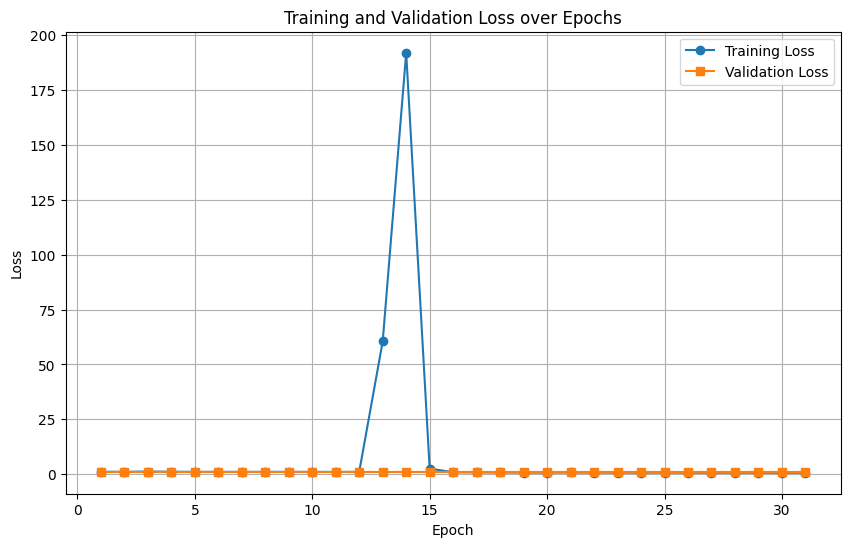

In [309]:
import matplotlib.pyplot as plt

# Collect validation loss for each epoch
# Assuming 'val_loss' is calculated for each epoch in your training loop
validation_losses = [val_loss for epoch in range(len(epoch_losses))]

# Plot Training and Validation Loss over Epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_losses) + 1), validation_losses, marker='s', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [310]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np

# --- Evaluation on Test Data ---
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        labels = batch["resampled_label"].to(device)
        
        logits = model(input_ids)
        preds = torch.argmax(logits, dim=-1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


# --- Classification Report ---
print("Classification Report:\n", classification_report(all_labels, all_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.10      0.17       466
           1       0.58      0.85      0.69       466
           2       0.72      0.98      0.83       466

    accuracy                           0.65      1398
   macro avg       0.64      0.65      0.56      1398
weighted avg       0.64      0.65      0.56      1398



In [311]:
from transformers import AutoTokenizer

# Load tokenizer (ensure it's the same one used during training)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def predict(text, model, device):
    model.eval()
    
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
    with torch.no_grad():
        logits = model(inputs["input_ids"])
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
    
    return preds[0]

# Test with sample texts
sample_texts = [
    "Enjoying a beautiful day at the park!"
   
]

# Run inference
for text in sample_texts:
    pred_label = predict(text, model, device)
    print(f"Text: {text}\nPredicted Label: {pred_label}\n")


Text: Enjoying a beautiful day at the park!
Predicted Label: 1



In [312]:
from transformers import AutoTokenizer
import torch

# Load tokenizer (ensure it's the same one used during training)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Define label mapping
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

def predict(text, model, device):
    model.eval()
    
    # Tokenize input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
    with torch.no_grad():
        logits = model(inputs["input_ids"])
        # Print logits for debugging
        print(f"Logits: {logits}")
        
        # Get the class with the highest probability
        pred = torch.argmax(logits, dim=-1).item()
        
        # Check if the prediction matches our expected classes
        if pred not in label_map:
            print(f"Warning: Prediction {pred} does not match expected classes.")
            return "Unknown"
        
        return label_map[pred]


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Ensure your model is on the correct device

# Test with sample texts
sample_texts = [
    "I absolutely love this product! It works perfectly.",
    "This was the worst experience I've ever had.",
    "The movie was okay, nothing special but not bad either.",
    "I'm extremely happy with my purchase!",
    "The service was terrible, I regret coming here.",
    "It was an average day, nothing exciting happened.",
    "The staff was very friendly and helpful.",
    "I wouldn’t recommend this to anyone, it’s a complete waste of money.",
    "I don’t know how to feel about this, it’s just alright I guess.",
    "Fantastic quality and amazing customer support!",
    "I feel so disappointed with what I received.",
    "Not great, not terrible, just meh.",
    "Best decision I’ve made in a long time!",
    "I am so frustrated with how slow everything is.",
    "Everything went smoothly, no complaints.",
    "I’m beyond excited about this opportunity!",
    "The food was bland and overpriced.",
    "Decent performance, but could have been better.",
    "I can’t stop smiling, today was wonderful!",
    "It left me feeling empty and unsatisfied."
]


# Run inference
for text in sample_texts:
    pred_label = predict(text, model, device)
    print(f"Text: {text}\nPredicted Label: {pred_label}\n")

Logits: tensor([[-5.0672, 11.6336,  3.4579]], device='cuda:0')
Text: I absolutely love this product! It works perfectly.
Predicted Label: Neutral

Logits: tensor([[0.5372, 1.6764, 0.8736]], device='cuda:0')
Text: This was the worst experience I've ever had.
Predicted Label: Neutral

Logits: tensor([[0.5056, 0.7889, 1.1422]], device='cuda:0')
Text: The movie was okay, nothing special but not bad either.
Predicted Label: Positive

Logits: tensor([[0.1648, 2.2091, 1.1105]], device='cuda:0')
Text: I'm extremely happy with my purchase!
Predicted Label: Neutral

Logits: tensor([[0.6556, 0.6448, 0.9744]], device='cuda:0')
Text: The service was terrible, I regret coming here.
Predicted Label: Positive

Logits: tensor([[ 0.4665, -0.1633,  0.6480]], device='cuda:0')
Text: It was an average day, nothing exciting happened.
Predicted Label: Positive

Logits: tensor([[-15.5824,  21.7615,   5.0985]], device='cuda:0')
Text: The staff was very friendly and helpful.
Predicted Label: Neutral

Logits: ten